# Компьютерное зрение: задача сегментации

* Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
* Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры.
* Попробовать улучшить качество изменяя архитектуру.

In [4]:
import copy
import random
import cv2
from pathlib import Path

import torch
from matplotlib import pyplot as plt
from torch import nn
from torchvision import transforms
from torchvision.transforms import functional
from tqdm.auto import tqdm, trange

In [5]:
def reset_random_seeds():
    torch.manual_seed(42)
    random.seed(42)

# Реализация UNet

Реализация взята с пары

In [7]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

In [8]:
class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down),
                               first_out_channels * (2 ** (n_down - 1)),
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

# Подготовка данных



In [9]:
from torch.utils.data import Dataset
from torchvision import io, transforms

class SelfieDataset(Dataset):
    def __init__(self, imgs_list, mask_list):
        self.imgs = sorted(imgs_list)
        self.masks = sorted(mask_list)
        self.transform = lambda x: x

    def _crop_image(self, img):
      return transforms.functional.crop(img, 0, 0, 768, 512) # we need this for correct pooling

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = io.read_image(self.imgs[idx]) / 255
        mask = io.read_image(self.masks[idx]) / 255
        
        return self.transform(self._crop_image(img)), self.transform(self._crop_image(mask))

In [10]:
reset_random_seeds()

Train size:  1800
Test size:  200
Image tensor shape: torch.Size([3, 768, 512])
Mask tensor shape: torch.Size([1, 768, 512])


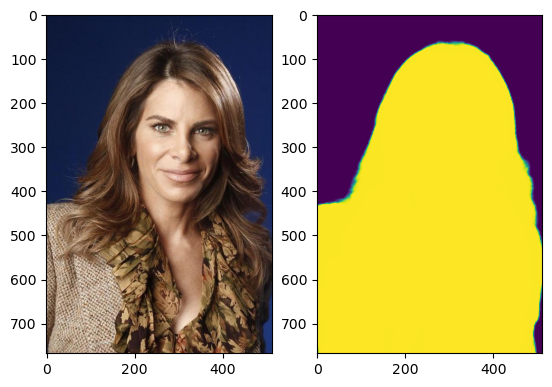

In [11]:
from glob import glob

def show_image_and_mask(image, mask):
  fig = plt.figure()
  fig.add_subplot(1, 2, 1)
  plt.imshow(image.permute(1, 2, 0))
  fig.add_subplot(1, 2, 2)
  plt.imshow(mask.permute(1, 2, 0))
  plt.show()

imgs_list = glob("/kaggle/input/selfie/dataset/images/*")
mask_list = glob("/kaggle/input/selfie/dataset/masks/*")

train_portion = 0.9
train_dataset = SelfieDataset(
    imgs_list[:int(len(imgs_list) * train_portion)],
    mask_list[:int(len(imgs_list) * train_portion)]
)
test_dataset = SelfieDataset(
    imgs_list[int(len(imgs_list) * train_portion):],
    mask_list[int(len(imgs_list) * train_portion):]
)

print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))

image, mask = train_dataset[0]
print("Image tensor shape:", image.size())
print("Mask tensor shape:", mask.size())

show_image_and_mask(image, mask)


# Переобучение на 4 картинках

In [8]:
from torch.utils.data import DataLoader, Subset

batch_size = 4

train_loader = DataLoader(
    Subset(train_dataset, range(batch_size)),
    batch_size=batch_size,
)
test_loader = DataLoader(
    Subset(test_dataset, range(batch_size)),
    batch_size=batch_size,
)

In [9]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
















In [16]:
from tqdm.auto import tqdm
from torch.optim import Adam
import torchmetrics

criterion = nn.BCEWithLogitsLoss()
jaccard = torchmetrics.JaccardIndex(task="binary")

def test(model, loader):
  model.eval()

  running_loss = 0.0
  jaccard_metric = 0.0
  with torch.no_grad():
      for x, y in tqdm(loader):
          outputs = model(x.cuda())
          running_loss += criterion(outputs, y.cuda()).item()
          jaccard_metric += (jaccard(outputs.cpu(), y.cpu() > jaccard.threshold)).item()

  return (running_loss / len(loader), jaccard_metric / len(loader))

def train(epochs, model, train_loader, test_loader, optimizer):
  train_stats = []
  test_stats = []
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    jaccard_metric = 0.0
    for x, y in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(x.cuda())

        loss = criterion(outputs, y.cuda())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        jaccard_metric += (jaccard(outputs.cpu(), y.cpu() > jaccard.threshold)).item()

    train_stat = (running_loss / len(train_loader), jaccard_metric / len(train_loader))
    test_stat = test(model, test_loader)
    train_stats.append(train_stat)
    test_stats.append(test_stat)
    print("Epoch:", epoch + 1, ", train: ", train_stat, ", test: ", test_stat)
  
  return train_stats, test_stats

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [11]:
model = UNET(3, 16, 1).cuda()
optimizer = Adam(model.parameters())

train_stats, test_stats = train(
    100, model, train_loader, test_loader, optimizer
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 , train:  (0.7673954963684082, 0.2022651731967926) , test:  (0.6994461417198181, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2 , train:  (0.7140642404556274, 0.22474630177021027) , test:  (0.7013705968856812, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3 , train:  (0.6908103823661804, 0.370322585105896) , test:  (0.7032068967819214, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4 , train:  (0.6718857288360596, 0.463909775018692) , test:  (0.704776406288147, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5 , train:  (0.6518818140029907, 0.5352811813354492) , test:  (0.7061564326286316, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6 , train:  (0.6295508146286011, 0.5955178737640381) , test:  (0.7075287699699402, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7 , train:  (0.607406497001648, 0.6440637111663818) , test:  (0.7090162038803101, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8 , train:  (0.6012855768203735, 0.6818329095840454) , test:  (0.7111907005310059, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9 , train:  (0.5802434682846069, 0.7319122552871704) , test:  (0.7140581607818604, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10 , train:  (0.5592167377471924, 0.7780175805091858) , test:  (0.7182831168174744, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11 , train:  (0.5347790122032166, 0.8114542365074158) , test:  (0.7260107398033142, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12 , train:  (0.5139807462692261, 0.8217892050743103) , test:  (0.739496648311615, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13 , train:  (0.4922007918357849, 0.839708149433136) , test:  (0.7667282819747925, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14 , train:  (0.46644091606140137, 0.8539051413536072) , test:  (0.8225666880607605, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15 , train:  (0.47962459921836853, 0.8451337218284607) , test:  (0.928562581539154, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 16 , train:  (0.44906505942344666, 0.8753381967544556) , test:  (0.947828471660614, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 17 , train:  (0.4570392966270447, 0.8564209938049316) , test:  (1.1542702913284302, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 18 , train:  (0.44038817286491394, 0.8814253807067871) , test:  (1.5900166034698486, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 19 , train:  (0.4283849000930786, 0.8933479189872742) , test:  (2.001373291015625, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 20 , train:  (0.4171898365020752, 0.9050887227058411) , test:  (2.443164825439453, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 21 , train:  (0.4281478822231293, 0.8782640695571899) , test:  (2.7479732036590576, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 22 , train:  (0.41242489218711853, 0.896408200263977) , test:  (2.4531009197235107, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 23 , train:  (0.40515846014022827, 0.9006682634353638) , test:  (2.1915907859802246, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 24 , train:  (0.39966338872909546, 0.9062480330467224) , test:  (2.24501633644104, 0.0)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 25 , train:  (0.39373159408569336, 0.912764310836792) , test:  (2.3610057830810547, 0.0014473103219643235)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 26 , train:  (0.39921078085899353, 0.9035271406173706) , test:  (2.983407497406006, 0.002172674285247922)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 27 , train:  (0.3964776396751404, 0.9105342626571655) , test:  (3.2440943717956543, 0.027134932577610016)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 28 , train:  (0.38949352502822876, 0.9159395098686218) , test:  (3.0268819332122803, 0.08887489140033722)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 29 , train:  (0.38327282667160034, 0.9249248504638672) , test:  (2.4374399185180664, 0.22002150118350983)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 30 , train:  (0.38270092010498047, 0.9223595857620239) , test:  (2.187714099884033, 0.29121133685112)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 31 , train:  (0.3721514344215393, 0.9261506795883179) , test:  (2.1014859676361084, 0.3307638466358185)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 32 , train:  (0.37518593668937683, 0.9250331521034241) , test:  (1.9826321601867676, 0.35087937116622925)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 33 , train:  (0.37062209844589233, 0.9291096329689026) , test:  (1.7445151805877686, 0.3820033371448517)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 34 , train:  (0.35992130637168884, 0.938322901725769) , test:  (1.4463129043579102, 0.4356135427951813)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 35 , train:  (0.35094162821769714, 0.95026034116745) , test:  (1.2466585636138916, 0.46692121028900146)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 36 , train:  (0.345140278339386, 0.9556035399436951) , test:  (1.1656169891357422, 0.4782479405403137)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 37 , train:  (0.3415600061416626, 0.9554376602172852) , test:  (1.188544511795044, 0.4714494049549103)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 38 , train:  (0.34647852182388306, 0.9473682641983032) , test:  (1.0443885326385498, 0.5413601994514465)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 39 , train:  (0.3381659686565399, 0.9576369524002075) , test:  (0.9980522394180298, 0.556817352771759)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 40 , train:  (0.33885061740875244, 0.9540845155715942) , test:  (0.9406780004501343, 0.5699620842933655)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 41 , train:  (0.33426451683044434, 0.9546560645103455) , test:  (0.8738507628440857, 0.5896580815315247)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 42 , train:  (0.3248092234134674, 0.9647426009178162) , test:  (0.8126599192619324, 0.6089027523994446)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 43 , train:  (0.3324015438556671, 0.951668918132782) , test:  (0.8765944242477417, 0.5711572766304016)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 44 , train:  (0.32143402099609375, 0.9633786678314209) , test:  (0.9093167185783386, 0.5509086847305298)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 45 , train:  (0.31802043318748474, 0.9648495316505432) , test:  (0.8948912024497986, 0.5592153072357178)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 46 , train:  (0.31446143984794617, 0.9673258662223816) , test:  (0.8643035888671875, 0.5766245722770691)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 47 , train:  (0.3112761378288269, 0.9684551358222961) , test:  (0.8302785754203796, 0.5921662449836731)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 48 , train:  (0.30839136242866516, 0.9698088765144348) , test:  (0.7809728384017944, 0.614932656288147)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 49 , train:  (0.30487531423568726, 0.9708645939826965) , test:  (0.7484465837478638, 0.6261253356933594)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 50 , train:  (0.30160391330718994, 0.9719696044921875) , test:  (0.7482540011405945, 0.6189846992492676)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 51 , train:  (0.2998587191104889, 0.9708425998687744) , test:  (0.7470955848693848, 0.6198259592056274)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 52 , train:  (0.29561126232147217, 0.9745477437973022) , test:  (0.735914409160614, 0.6291996240615845)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 53 , train:  (0.29364949464797974, 0.9749727249145508) , test:  (0.7419939041137695, 0.6262808442115784)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 54 , train:  (0.29053205251693726, 0.9762812256813049) , test:  (0.7269768714904785, 0.6359452605247498)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 55 , train:  (0.2884058356285095, 0.9757781624794006) , test:  (0.7002571821212769, 0.6536434888839722)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 56 , train:  (0.28497689962387085, 0.9778428077697754) , test:  (0.6921960711479187, 0.6560974717140198)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 57 , train:  (0.28217658400535583, 0.9782578349113464) , test:  (0.6638668775558472, 0.6756690740585327)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 58 , train:  (0.2801452875137329, 0.978563666343689) , test:  (0.6614907383918762, 0.683381974697113)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 59 , train:  (0.2765994668006897, 0.9808780550956726) , test:  (0.6503787040710449, 0.6961795687675476)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 60 , train:  (0.27475741505622864, 0.9810278415679932) , test:  (0.6456272602081299, 0.7009236216545105)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 61 , train:  (0.2717556357383728, 0.9820510149002075) , test:  (0.6519870758056641, 0.6952418088912964)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 62 , train:  (0.26938867568969727, 0.9822872877120972) , test:  (0.6525180339813232, 0.6933035254478455)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 63 , train:  (0.2675219476222992, 0.9825897812843323) , test:  (0.6604276895523071, 0.6884885430335999)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 64 , train:  (0.2649436891078949, 0.9830498695373535) , test:  (0.6385259628295898, 0.70680171251297)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 65 , train:  (0.2631078362464905, 0.9825928211212158) , test:  (0.6525745391845703, 0.700863242149353)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 66 , train:  (0.26113033294677734, 0.9830222129821777) , test:  (0.6227459907531738, 0.7206820249557495)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 67 , train:  (0.25968724489212036, 0.9820559024810791) , test:  (0.6605692505836487, 0.6971142292022705)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 68 , train:  (0.26214224100112915, 0.9767383933067322) , test:  (0.598706841468811, 0.7379311323165894)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 69 , train:  (0.2611745297908783, 0.975462019443512) , test:  (0.625085711479187, 0.7235230803489685)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 70 , train:  (0.2561037540435791, 0.9799564480781555) , test:  (0.6243128776550293, 0.7246596813201904)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 71 , train:  (0.25440725684165955, 0.9801632165908813) , test:  (0.5951669812202454, 0.7418115735054016)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 72 , train:  (0.2531570494174957, 0.9785099625587463) , test:  (0.61277174949646, 0.7337170839309692)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 73 , train:  (0.24901114404201508, 0.9818323850631714) , test:  (0.6016470193862915, 0.7425196766853333)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 74 , train:  (0.248874232172966, 0.9803357720375061) , test:  (0.5853649973869324, 0.7510412335395813)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 75 , train:  (0.24524742364883423, 0.982383131980896) , test:  (0.5828449726104736, 0.7514945268630981)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 76 , train:  (0.24374723434448242, 0.9825336933135986) , test:  (0.594046950340271, 0.7459783554077148)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 77 , train:  (0.24275092780590057, 0.9809699058532715) , test:  (0.6072580218315125, 0.7382515072822571)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 78 , train:  (0.23891934752464294, 0.9836210608482361) , test:  (0.5971003770828247, 0.7445840835571289)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 79 , train:  (0.23859427869319916, 0.9822794198989868) , test:  (0.591535210609436, 0.7478803992271423)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 80 , train:  (0.23468568921089172, 0.9853870272636414) , test:  (0.591010332107544, 0.74787437915802)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 81 , train:  (0.23386216163635254, 0.9837143421173096) , test:  (0.5891290903091431, 0.7492061257362366)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 82 , train:  (0.23123620450496674, 0.9853575229644775) , test:  (0.596180260181427, 0.7452133893966675)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 83 , train:  (0.229239821434021, 0.9859099388122559) , test:  (0.5978618264198303, 0.7449336051940918)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 84 , train:  (0.2277386635541916, 0.9859759211540222) , test:  (0.5940117239952087, 0.7472521662712097)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 85 , train:  (0.2255460023880005, 0.9862850904464722) , test:  (0.5786590576171875, 0.7549380660057068)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 86 , train:  (0.22362497448921204, 0.98699951171875) , test:  (0.5821870565414429, 0.7525400519371033)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 87 , train:  (0.22161059081554413, 0.9875087738037109) , test:  (0.5916054844856262, 0.7469305396080017)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 88 , train:  (0.21998250484466553, 0.9873908758163452) , test:  (0.5877257585525513, 0.7488298416137695)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 89 , train:  (0.21796761453151703, 0.9879998564720154) , test:  (0.5802613496780396, 0.7530956864356995)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 90 , train:  (0.21683596074581146, 0.987664520740509) , test:  (0.5976531505584717, 0.7443370819091797)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 91 , train:  (0.2148744910955429, 0.9880708456039429) , test:  (0.6019690036773682, 0.7418383359909058)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 92 , train:  (0.21329498291015625, 0.9883344173431396) , test:  (0.5888717174530029, 0.7481768727302551)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 93 , train:  (0.21142145991325378, 0.9888049960136414) , test:  (0.5854895114898682, 0.7503082752227783)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 94 , train:  (0.20970147848129272, 0.9891965985298157) , test:  (0.5955907106399536, 0.746265709400177)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 95 , train:  (0.20834724605083466, 0.9885568618774414) , test:  (0.6035327911376953, 0.7418504357337952)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 96 , train:  (0.20733118057250977, 0.988185703754425) , test:  (0.5949589014053345, 0.7465589642524719)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 97 , train:  (0.20615974068641663, 0.9880551099777222) , test:  (0.5958247184753418, 0.7468519806861877)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 98 , train:  (0.20373952388763428, 0.9894699454307556) , test:  (0.59621661901474, 0.7467891573905945)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 99 , train:  (0.20266079902648926, 0.9882875680923462) , test:  (0.5982192754745483, 0.7453120350837708)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 100 , train:  (0.20145127177238464, 0.988226592540741) , test:  (0.6110427379608154, 0.7392455339431763)


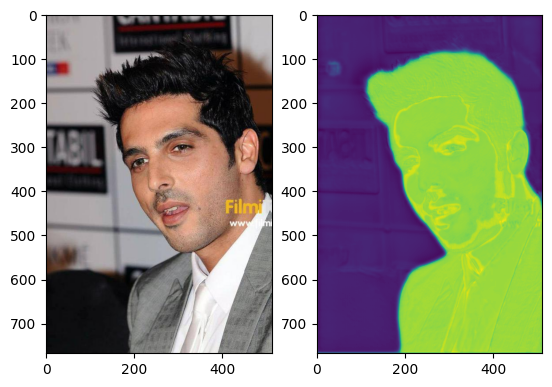

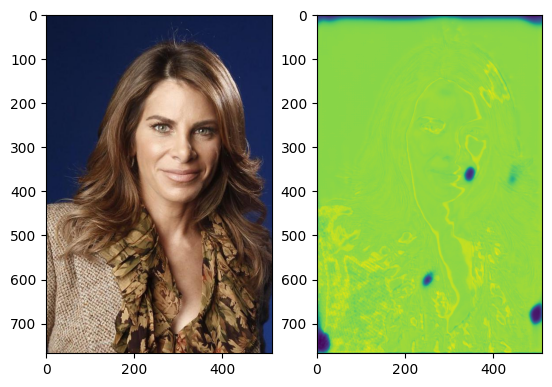

In [12]:
model.eval()

X, _ = train_dataset[0]
with torch.no_grad():
    pred = model(X.cuda().unsqueeze(0))[0].cpu()
show_image_and_mask(X, pred)

X, _ = test_dataset[0]
with torch.no_grad():
    pred = model(X.cuda().unsqueeze(0))[0].cpu()
show_image_and_mask(X, pred)

In [18]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

def show_stats(stats, title):
  results = []
  i = 1
  for loss, jaccard in stats:
    results.append(
        {
            "Epoch": i,
            "Metric type": "Loss",
            "Value": loss,
        }
    )
    results.append(
        {
            "Epoch": i,
            "Metric type": "Jaccard",
            "Value": jaccard,
        }
    )
    i += 1
  df = pd.DataFrame(results)
  sns.lineplot(x="Epoch", y="Value", hue="Metric type", data=df).set(title=title)
  plt.show()


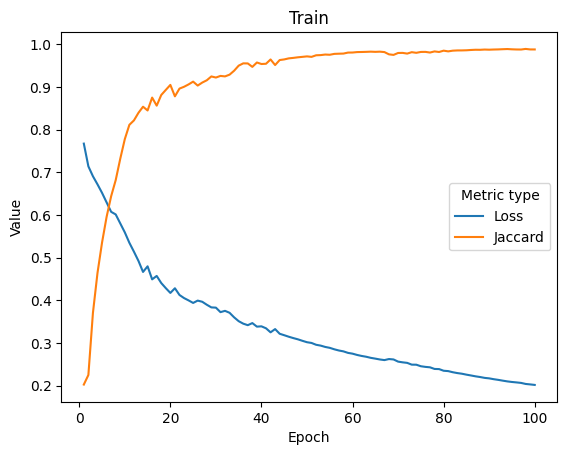

In [13]:
show_stats(train_stats, "Train")

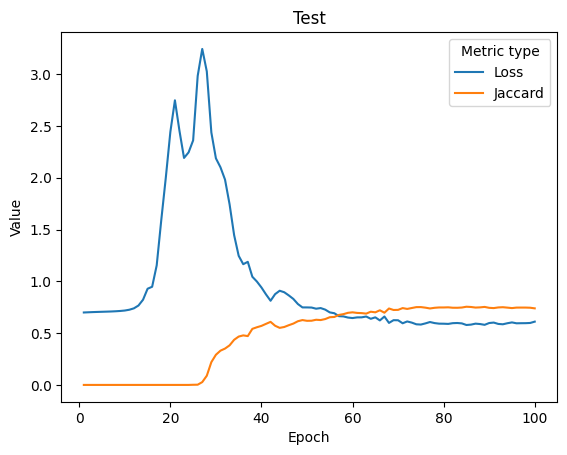

In [14]:
show_stats(test_stats, "Test")

Как и ожидалось, при переобучении модели на 4 картинках, она почти идельно выделяет объкт на них, и плохо работает на тестовом наборе.

# Обучение модели на всей совокупности данных

In [17]:
batch_size = 20

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)

model = UNET(3, 16, 1).cuda()
optimizer = Adam(model.parameters())

train_stats, test_stats = train(
    30, model, train_loader, test_loader, optimizer
)

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 , train:  (0.6041052639484406, 0.5714573002523846) , test:  (0.540096041560173, 0.6271593511104584)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2 , train:  (0.5035411513513989, 0.6405961957242754) , test:  (0.49988189041614534, 0.6451350152492523)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3 , train:  (0.47237503661049735, 0.6635301205846998) , test:  (0.49514966309070585, 0.6694881677627563)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4 , train:  (0.4553183697991901, 0.6742525882191128) , test:  (0.4637226700782776, 0.6733195006847381)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5 , train:  (0.44264729585912493, 0.6811745511160956) , test:  (0.4511134386062622, 0.6875819206237793)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6 , train:  (0.43186270263459947, 0.6895779490470886) , test:  (0.43479515612125397, 0.6907408833503723)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7 , train:  (0.4246261106597053, 0.6967655479907989) , test:  (0.44621312618255615, 0.6921214878559112)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8 , train:  (0.4208213839266035, 0.6991291814380222) , test:  (0.41690549850463865, 0.6958941340446472)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9 , train:  (0.41438794715536964, 0.7051106923156314) , test:  (0.4213398903608322, 0.7008192121982575)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10 , train:  (0.4120552231868108, 0.7075559410783979) , test:  (0.41956329345703125, 0.6956378281116485)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11 , train:  (0.40760688185691835, 0.7103036105632782) , test:  (0.4056115299463272, 0.7111414015293122)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12 , train:  (0.40015191005335915, 0.7166264858510759) , test:  (0.4062131464481354, 0.7090161204338074)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13 , train:  (0.3951001705394851, 0.7205522616704305) , test:  (0.3944924622774124, 0.7168352365493774)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14 , train:  (0.39250194860829246, 0.7223201321230994) , test:  (0.4012566179037094, 0.7174450933933259)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15 , train:  (0.3891440562076039, 0.7249070876174503) , test:  (0.3891355812549591, 0.7163759112358093)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16 , train:  (0.38609136525127624, 0.7276109450393253) , test:  (0.3890893876552582, 0.7169714391231536)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17 , train:  (0.38368546118338903, 0.7298255960146586) , test:  (0.39371276199817656, 0.7217576205730438)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18 , train:  (0.3824920309914483, 0.7303569104936388) , test:  (0.38052356243133545, 0.719877940416336)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19 , train:  (0.3790408910976516, 0.732189310921563) , test:  (0.3777423083782196, 0.7290301978588104)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20 , train:  (0.3770962271425459, 0.7348725299040476) , test:  (0.3841789811849594, 0.7275517821311951)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21 , train:  (0.3754945049683253, 0.7353077901734246) , test:  (0.38857032358646393, 0.717255049943924)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22 , train:  (0.3721957686874602, 0.7370827284124163) , test:  (0.38139469623565675, 0.7207930088043213)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23 , train:  (0.3694612403710683, 0.7399826208750407) , test:  (0.3838857144117355, 0.7269990861415863)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24 , train:  (0.3686643332242966, 0.7395885368188222) , test:  (0.3829541802406311, 0.7217423021793365)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25 , train:  (0.3680508532457881, 0.7404410805967119) , test:  (0.37668798863887787, 0.7306471288204193)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26 , train:  (0.36541915784279505, 0.7418442792362637) , test:  (0.37354910373687744, 0.7286741852760314)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27 , train:  (0.3627820677227444, 0.7446888890531328) , test:  (0.3754259631037712, 0.7280280530452728)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28 , train:  (0.36020538757244747, 0.7467049810621473) , test:  (0.3785366013646126, 0.724265968799591)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29 , train:  (0.35780829886595406, 0.74813877609041) , test:  (0.38074190318584444, 0.7243334352970123)


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30 , train:  (0.35653242684072917, 0.7490574664539761) , test:  (0.38038820028305054, 0.7317762911319733)


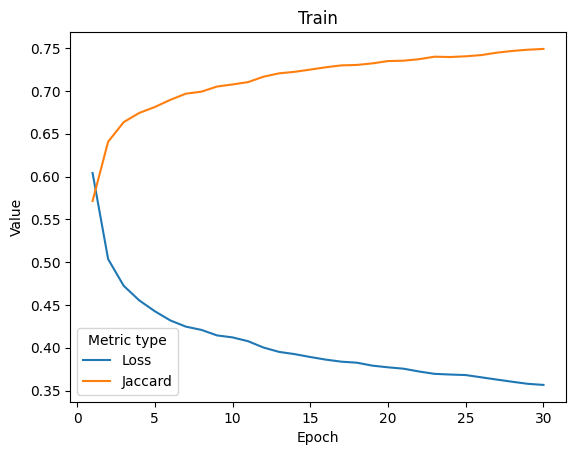

In [19]:
show_stats(train_stats, "Train")

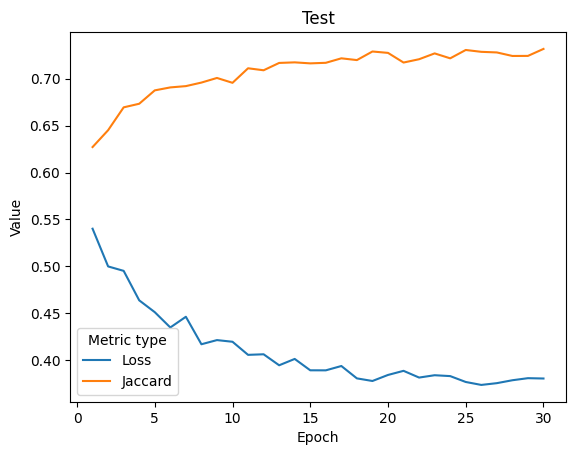

In [20]:
show_stats(test_stats, "Test")

Как можно видеть, между 20 и 30 эпохами обучения существенной разницы в изменении ошибки или индекса Жакара на тестовой выборке не наблюдалось. Скорее всего модель в своем текущем виде уже достигла наилучшего результата, которого могла

In [31]:
import functools

model.eval()

def worst_test_cases(model, n):
    results = []
    with torch.no_grad():
        for x, y in tqdm(test_loader):
            outputs = model(x.cuda())
            jaccard_metric = (jaccard(outputs.cpu(), y.cpu() > jaccard.threshold)).item()
            results.append((outputs[0], jaccard_metric, x))

    return sorted(results, key=functools.cmp_to_key(lambda a, b: a[1] - b[1]))[:n]

worst = worst_test_cases(model, 3)

  0%|          | 0/10 [00:00<?, ?it/s]

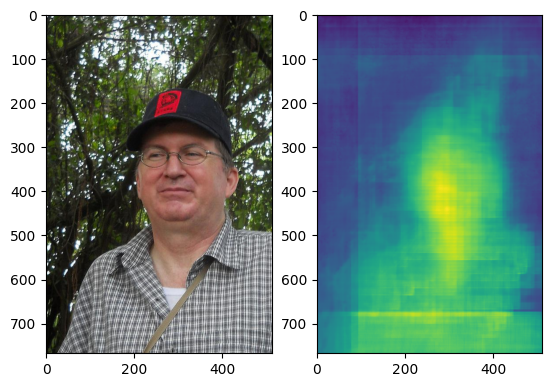

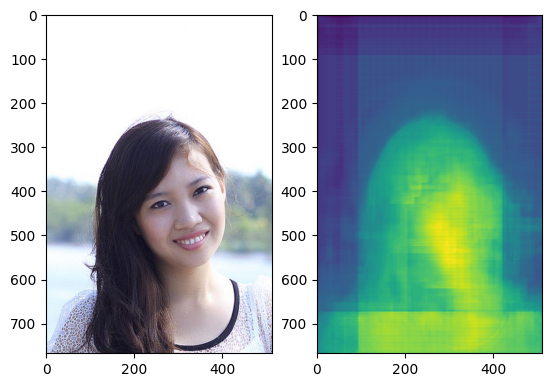

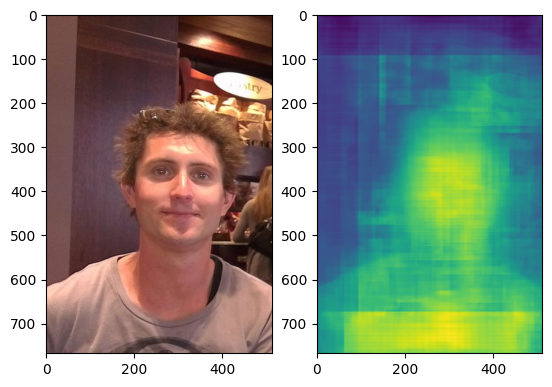

In [33]:
for outputs, j, x in worst:
  show_image_and_mask(x[0], outputs.cpu())

Видно, что модель довольно хорошо определяет маску даже для самых худших случаев.

# Улучшение модели

### Аугментации

Попробуем увеличить количество тренировочных данных с помощью аугментации. Для каждого изображения заведем его копию со случайным поворотом.

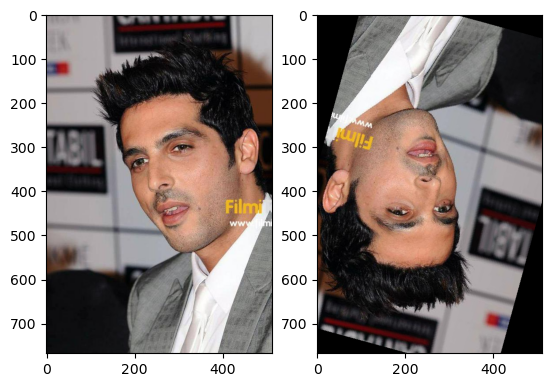

In [21]:
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader

reset_random_seeds()

batch_size = 20

augmentations = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180)),
    ]
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = augmentations

image, _ = train_dataset[1]
augmented_image, _ = train_dataset_augmented[1]
show_image_and_mask(image, augmented_image)

train_dataset_extended = ConcatDataset(
    [train_dataset, train_dataset_augmented]
)

train_loader_extended = DataLoader(train_dataset_extended, batch_size=batch_size, shuffle=True)

### Гиперпараметры

В качестве гиперпараметра сети попробуем изменять количество уровней UNET. На данный момент по умолчанию мы используем 4 уровня, посмотрим, что будет если использовать 3 и 5 уровней.

In [11]:
levels = [3, 4, 5]
results = dict()

for level in levels:
    model = UNET(3, 16, 1, level).cuda()
    optimizer = Adam(model.parameters())

    train_stats, test_stats = train(
        30, model, train_loader_extended, test_loader, optimizer
    )
    results[level] = (model.cpu(), train_stats, test_stats)

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 , train:  (0.6213495042588976, 0.46013178245888814) , test:  (0.5811555683612823, 0.5932279825210571)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2 , train:  (0.5894038657347361, 0.5138456581367387) , test:  (0.5635895490646362, 0.5421401798725128)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3 , train:  (0.5852871623304156, 0.5153768468234274) , test:  (0.5510275661945343, 0.5825912654399872)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4 , train:  (0.5781046231587728, 0.5234339738885562) , test:  (0.5908154964447021, 0.5733932077884674)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5 , train:  (0.5752954459852643, 0.5277099180552695) , test:  (0.5388376593589783, 0.5961414277553558)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6 , train:  (0.5730026354392369, 0.5254467290308741) , test:  (0.5420097708702087, 0.5921242833137512)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7 , train:  (0.5724109811915292, 0.5280457042985492) , test:  (0.5397470831871033, 0.6029940366744995)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8 , train:  (0.568743712703387, 0.5288893699645996) , test:  (0.5248541116714478, 0.6172997534275055)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9 , train:  (0.5667764100763533, 0.533061745431688) , test:  (0.5309781074523926, 0.598074096441269)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10 , train:  (0.5674698577986823, 0.5318655245833926) , test:  (0.5537445724010468, 0.5711863279342652)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11 , train:  (0.5634808113177617, 0.5345343101355765) , test:  (0.5183183223009109, 0.6261279702186584)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12 , train:  (0.5610836201243931, 0.5353985925515493) , test:  (0.5286790013313294, 0.6074355363845825)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13 , train:  (0.5577516376972198, 0.5401198893785477) , test:  (0.50837262570858, 0.6229453146457672)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14 , train:  (0.5598080057236884, 0.5369657117459509) , test:  (0.538437408208847, 0.5640197694301605)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15 , train:  (0.5578994035720826, 0.5408052166302999) , test:  (0.5279953122138977, 0.6203724086284638)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16 , train:  (0.556377242008845, 0.543122113082144) , test:  (0.5170482635498047, 0.607462465763092)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17 , train:  (0.5543768025106854, 0.5413478798336453) , test:  (0.5169769287109375, 0.6332432866096497)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18 , train:  (0.5536653271979756, 0.5397435448235935) , test:  (0.5065648645162583, 0.6269119262695313)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19 , train:  (0.5529270398947927, 0.5413089975714683) , test:  (0.5255077838897705, 0.6165916681289673)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20 , train:  (0.5479234168926875, 0.5494676664471626) , test:  (0.5022921621799469, 0.6440198600292206)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21 , train:  (0.5472116058071455, 0.5460097543067403) , test:  (0.5060284227132797, 0.6260241389274597)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22 , train:  (0.5431937812103166, 0.5453551949726211) , test:  (0.5098595649003983, 0.6497479319572449)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23 , train:  (0.5404283175865809, 0.5496196107731925) , test:  (0.5006893962621689, 0.6425476968288422)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24 , train:  (0.5385961300796933, 0.55149973862701) , test:  (0.5051417857408523, 0.6233214378356934)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25 , train:  (0.5363432885871993, 0.5520259135299259) , test:  (0.48847222328186035, 0.6278978109359741)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26 , train:  (0.5346444032258457, 0.5547982093360689) , test:  (0.48617240190505984, 0.6312961995601654)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27 , train:  (0.5323587379521794, 0.5572027628620465) , test:  (0.4945751249790192, 0.611830061674118)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28 , train:  (0.5340741530060769, 0.5551410820749071) , test:  (0.48958063721656797, 0.6351325273513794)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29 , train:  (0.5291638334592184, 0.5579780255754788) , test:  (0.4914818048477173, 0.6440744996070862)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30 , train:  (0.5274658345513874, 0.5610349376996359) , test:  (0.4969760119915009, 0.6177314162254334)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 , train:  (0.6090732942024867, 0.48189468267891145) , test:  (0.6097573220729828, 0.5854010999202728)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2 , train:  (0.5705970701244142, 0.5337589679492845) , test:  (0.5329738855361938, 0.6219404399394989)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3 , train:  (0.5597546567519506, 0.5387709718611505) , test:  (0.5133038848638535, 0.6102800011634827)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4 , train:  (0.5464236683315701, 0.5503510130776299) , test:  (0.4922643035650253, 0.6422329187393189)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5 , train:  (0.5392195387019052, 0.5562740961710612) , test:  (0.47820826470851896, 0.6492158770561218)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6 , train:  (0.5296746138069365, 0.565547803706593) , test:  (0.46816072165966033, 0.6570302009582519)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7 , train:  (0.5224409782224231, 0.572008766233921) , test:  (0.4708726108074188, 0.6500736176967621)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8 , train:  (0.5215722809235255, 0.5706746651066674) , test:  (0.45645987093448637, 0.6605186581611633)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9 , train:  (0.518644184867541, 0.5726779571837849) , test:  (0.5047651916742325, 0.5743404150009155)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10 , train:  (0.5144913991292318, 0.5766952231526374) , test:  (0.44836200773715973, 0.6781359553337097)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11 , train:  (0.5147955122921202, 0.578131541940901) , test:  (0.46936466693878176, 0.6379892408847809)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12 , train:  (0.5115092007650269, 0.580244476099809) , test:  (0.4618514358997345, 0.6493769824504853)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13 , train:  (0.5101402648621135, 0.5808353025052283) , test:  (0.4528427213430405, 0.647443974018097)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14 , train:  (0.5104687641064326, 0.5821433699793286) , test:  (0.43942279517650606, 0.6835196256637573)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15 , train:  (0.5044505072964562, 0.5862663533952501) , test:  (0.4367923945188522, 0.6785951673984527)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16 , train:  (0.5044719581802686, 0.5854415539238188) , test:  (0.4362993001937866, 0.6841911315917969)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17 , train:  (0.5040764055318303, 0.5836287582914035) , test:  (0.435594716668129, 0.6662442743778229)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18 , train:  (0.5014617542425791, 0.5880512744188309) , test:  (0.43853033185005186, 0.6776904165744781)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19 , train:  (0.4996998950839043, 0.5885560085376104) , test:  (0.4274644434452057, 0.6885235786437989)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20 , train:  (0.4990368879503674, 0.5892078760597441) , test:  (0.4288701832294464, 0.68807373046875)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21 , train:  (0.4965668438209428, 0.5902214460902744) , test:  (0.42829529047012327, 0.6915163636207581)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22 , train:  (0.4952560568849246, 0.5947904755671819) , test:  (0.4234662115573883, 0.6861815035343171)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23 , train:  (0.4943941374619802, 0.5938189112477832) , test:  (0.4489174664020538, 0.6533793807029724)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24 , train:  (0.49565218951967027, 0.5954380348324776) , test:  (0.4201581448316574, 0.6866751551628113)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25 , train:  (0.4935187243753009, 0.594008802043067) , test:  (0.43826515674591066, 0.6736448287963868)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26 , train:  (0.49029641333553525, 0.5974958866834641) , test:  (0.4164412707090378, 0.701328444480896)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27 , train:  (0.4925933516687817, 0.5938672353823979) , test:  (0.41345287263393404, 0.6992052853107452)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28 , train:  (0.49190733035405476, 0.5955635946657922) , test:  (0.4188876062631607, 0.7011572659015656)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29 , train:  (0.4884992410739263, 0.5998507377174166) , test:  (0.4181787341833115, 0.680690985918045)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30 , train:  (0.48914512130949234, 0.6004636807574166) , test:  (0.4155939221382141, 0.6994405925273895)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 , train:  (0.588893018828498, 0.5158447126547495) , test:  (0.4689987301826477, 0.6376499891281128)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2 , train:  (0.5044694759779507, 0.5856006395485666) , test:  (0.4372736483812332, 0.6854861974716187)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3 , train:  (0.47543918523523543, 0.6004128754138947) , test:  (0.3733812838792801, 0.7396853387355804)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4 , train:  (0.4692665196127362, 0.604002790318595) , test:  (0.3754472851753235, 0.7391578853130341)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5 , train:  (0.4662915259599686, 0.6090505795346366) , test:  (0.36661861538887025, 0.7483548998832703)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6 , train:  (0.45844006290038425, 0.6162899028923776) , test:  (0.37558201551437376, 0.7250596523284912)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7 , train:  (0.4553163902627097, 0.6202353096670574) , test:  (0.3581616073846817, 0.7473449647426605)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8 , train:  (0.45345505956146454, 0.6209122869703505) , test:  (0.36832128167152406, 0.7430212676525116)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9 , train:  (0.45224422050846946, 0.6244524048434363) , test:  (0.34848142266273496, 0.753305459022522)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10 , train:  (0.4512906341089143, 0.624065159757932) , test:  (0.3474025011062622, 0.7547037422657012)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11 , train:  (0.4468656428986125, 0.6267591605583827) , test:  (0.34907607138156893, 0.752158397436142)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12 , train:  (0.44727566805150776, 0.6283904572327932) , test:  (0.34492761790752413, 0.7556874394416809)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13 , train:  (0.44580649750100243, 0.629074576497078) , test:  (0.3421573966741562, 0.7524280369281768)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14 , train:  (0.44664455751578014, 0.6276834898524815) , test:  (0.34564122259616853, 0.754412192106247)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15 , train:  (0.4443214444650544, 0.6302196996079551) , test:  (0.3511326670646667, 0.7549722075462342)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16 , train:  (0.4427354380488396, 0.6293578988975949) , test:  (0.34428382515907285, 0.7523880422115325)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17 , train:  (0.4432543181710773, 0.6302305658658346) , test:  (0.3613979071378708, 0.7458815574645996)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18 , train:  (0.4426186295019256, 0.6311024371120665) , test:  (0.3551695913076401, 0.7540512442588806)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19 , train:  (0.44421483874320983, 0.6283773654037051) , test:  (0.33638563454151155, 0.756120789051056)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20 , train:  (0.44049270782205796, 0.6328516844246123) , test:  (0.346763351559639, 0.7545809507369995)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21 , train:  (0.4415077833665742, 0.6302479128042857) , test:  (0.3483556628227234, 0.7481662571430207)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22 , train:  (0.4403734210464689, 0.6321018977297677) , test:  (0.34284078776836396, 0.7539754390716553)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23 , train:  (0.446264106200801, 0.6287521671917703) , test:  (0.3487425446510315, 0.7541563749313355)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24 , train:  (0.44214596251646676, 0.6318937785095639) , test:  (0.3382953405380249, 0.757730382680893)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25 , train:  (0.4386413334144486, 0.6336376832591163) , test:  (0.3481789082288742, 0.7470885753631592)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26 , train:  (0.43739505029386944, 0.6357829683356815) , test:  (0.3520719915628433, 0.7478111445903778)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27 , train:  (0.43622979356182945, 0.6341772079467773) , test:  (0.3398274004459381, 0.7573921144008636)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28 , train:  (0.43710826767815486, 0.6348923722902934) , test:  (0.3392141252756119, 0.7593828797340393)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29 , train:  (0.43819853530989755, 0.6336863077349133) , test:  (0.3716206580400467, 0.7227954745292664)


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30 , train:  (0.4351580270462566, 0.6366740203566021) , test:  (0.34603795111179353, 0.7484905600547791)


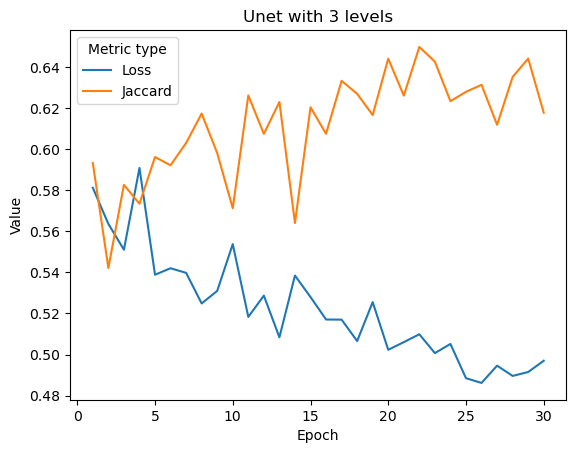

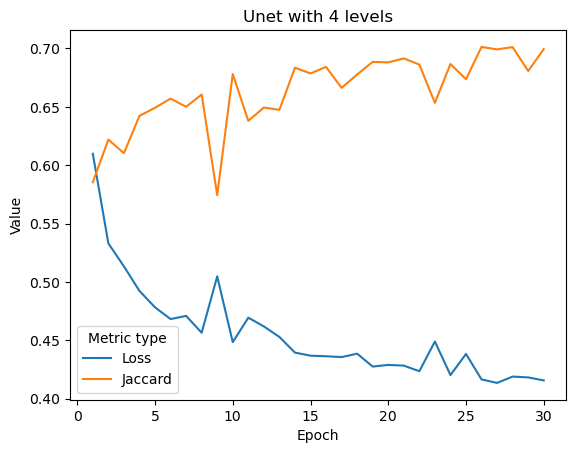

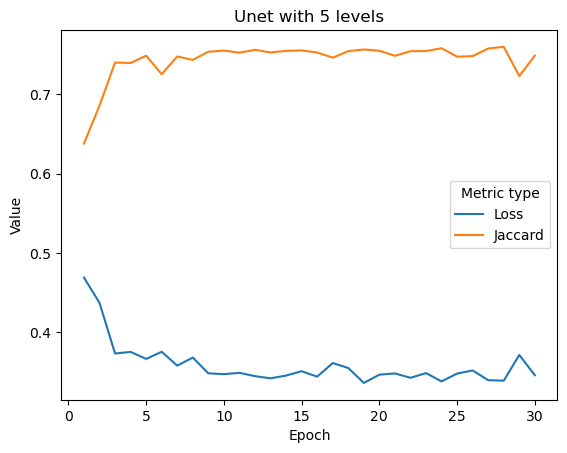

In [15]:
for level in levels:
    _, _, test_stats = results[level]
    show_stats(test_stats, "Unet with " + str(level) + " levels")

Видно, что модель с 5 уровнями смогла показать наилучший результат из всех. Также видно, что изменение агментация датасета не дала нам существенного выигрыша. Вероятно, стоило обучать модели подольше, и тогда выигрыш стал бы более очевиден.

# Улучшение модели через изменение архитектуры

Попробуем улучшить качество предсказания модели увеличив количество сверток на каждом уровне с 2 до 4

In [12]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=4, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down),
                               first_out_channels * (2 ** (n_down - 1)),
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

In [22]:
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader

reset_random_seeds()

batch_size = 4

augmentations = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180)),
    ]
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = augmentations

image, _ = train_dataset[1]
augmented_image, _ = train_dataset_augmented[1]

train_dataset_extended = ConcatDataset(
    [train_dataset, train_dataset_augmented]
)

train_loader_extended = DataLoader(train_dataset_extended, batch_size=batch_size, shuffle=True)

model = UNET(3, 16, 1).cuda()
optimizer = Adam(model.parameters())

train_stats, test_stats = train(
    30, model, train_loader_extended, test_loader, optimizer
)

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 , train:  (0.5923864471912385, 0.5104727373520533) , test:  (0.5599072182178497, 0.4164606112241745)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2 , train:  (0.5667685621976852, 0.5391078539358245) , test:  (0.5327754920721054, 0.5870817768573761)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3 , train:  (0.5590494794978036, 0.5468656695220205) , test:  (0.4970625311136246, 0.673170725107193)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 4 , train:  (0.5518007314867444, 0.5584200852447085) , test:  (0.4746046495437622, 0.6702572786808014)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 5 , train:  (0.5433005032605595, 0.567253749039438) , test:  (0.4786313223838806, 0.6541726577281952)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 6 , train:  (0.5349592967828115, 0.5709942728612158) , test:  (0.4586006236076355, 0.6900401616096496)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 7 , train:  (0.5281971196995842, 0.5753844640321202) , test:  (0.4561491405963898, 0.6526788747310639)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 8 , train:  (0.5181373497181468, 0.5809573473201858) , test:  (0.4414213216304779, 0.6769734990596771)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 9 , train:  (0.510183344648944, 0.5853359790643057) , test:  (0.4629235029220581, 0.642942476272583)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10 , train:  (0.5069145738416247, 0.5866345558563868) , test:  (0.4188214200735092, 0.6992944550514221)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 11 , train:  (0.5057555590073267, 0.5882046452826923) , test:  (0.4471911895275116, 0.6586460030078888)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 12 , train:  (0.5008426458968056, 0.591076087752978) , test:  (0.4320937168598175, 0.6889348268508911)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 13 , train:  (0.49712337689267266, 0.5942235732409689) , test:  (0.4126769512891769, 0.7049583065509796)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 14 , train:  (0.4939206589261691, 0.5978813734319475) , test:  (0.4008868497610092, 0.7204926919937134)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 15 , train:  (0.49161672873629464, 0.597944713069333) , test:  (0.4189653843641281, 0.6977725172042847)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 16 , train:  (0.48651354240046607, 0.6030480512314372) , test:  (0.40639157593250275, 0.6983333706855774)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 17 , train:  (0.48457792659600574, 0.603893592523204) , test:  (0.40432180643081667, 0.7065250396728515)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 18 , train:  (0.483530139459504, 0.6050279869304763) , test:  (0.4087286162376404, 0.7005544197559357)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 19 , train:  (0.48284865339597066, 0.6049388973911604) , test:  (0.3956497758626938, 0.7198887014389038)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 20 , train:  (0.47866728511121537, 0.6089319857954979) , test:  (0.3952323406934738, 0.7136433386802673)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 21 , train:  (0.47938554121388327, 0.60940657681889) , test:  (0.3895659840106964, 0.7231532549858093)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 22 , train:  (0.47870268748866185, 0.6091527968313959) , test:  (0.40624089002609254, 0.7227782392501831)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 23 , train:  (0.47765152355035145, 0.6102156668901444) , test:  (0.3981038188934326, 0.7216745960712433)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 24 , train:  (0.47573905958069695, 0.6111041903164651) , test:  (0.3921840864419937, 0.7268930578231811)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 25 , train:  (0.47444071342547733, 0.6125613051652908) , test:  (0.38692702889442443, 0.7240133690834045)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 26 , train:  (0.4735406205058098, 0.6131339721216096) , test:  (0.3853780448436737, 0.7252525067329407)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 27 , train:  (0.47222016566329533, 0.6139925863014327) , test:  (0.39188738286495206, 0.7245956838130951)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 28 , train:  (0.4714112444056405, 0.6139621825681792) , test:  (0.3859941440820694, 0.7243972396850586)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 29 , train:  (0.47196330630116995, 0.6146795995699035) , test:  (0.3888714027404785, 0.7265909588336945)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 30 , train:  (0.46912648227479725, 0.6157331963049041) , test:  (0.389561807513237, 0.7252625954151154)


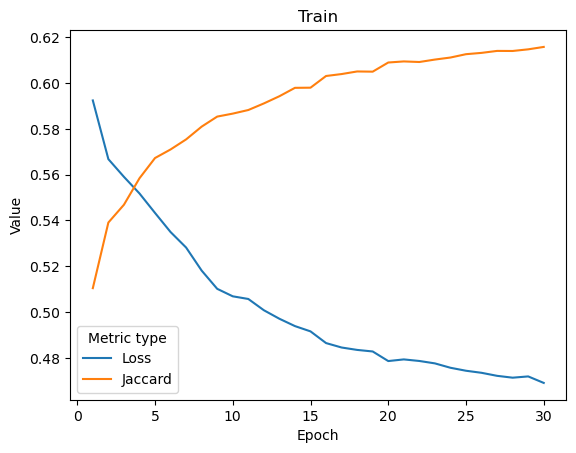

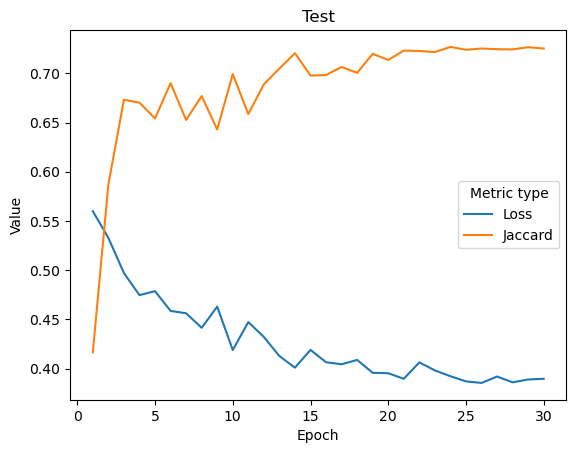

In [20]:
show_stats(train_stats, "Train")
show_stats(test_stats, "Test")

Модель с 4 свертками вместо 2 не смогла достичь принципиально лучших результатов, чем модель с 2 свертками. Индекс Жакара все также колеблется между 0.71 и 0.72.

# Вывод

Из полученных результатов можно сделать следующие выводы:
* Вероятно, можно было обучать модели подольше и получить результат получше, однако даже в самой обычной конфигурации Unet показывает отличную точность сегментации на предложенной задаче
* Увеличение количества уровней Unet наиболее существенно влияет на качество результирующей модели